Задачей проекта является разработка модели, которая будет предсказывать стоимость дома, основываясь на его характеристиках. Для оценки качества модели будут использоваться метрики MAE (Mean Absolute Error) – это среднее арифметическое модуля отклонения предсказанного значения от реального и MAPE (Mean Absolute Percent Error), которая показывает на сколько процентов в среднем предсказание модели отклоняется от реального значения.
      Перечислим признаки, которые содержатся в имеющихся данных и по которым будет обучаться модель: 
- статус продажи
- наличие бассейна
- тип недвижимости
- адрес
- количество ванных комнат
- год постройки дома
- год реконструкции
- тип отопления
- тип кондиционирования
- вид парковки автомобиля
- площадь земельного участка, прилагающегося к дому
- цена единицы площади участка
- наличие камина в доме
- город, в котором расположен дом
- рейтинги близлежащих школ
- расстояния до близлежащих школ
- жилая площадь
- количество спальных комнат
- штат, в котором расположен дом
- количество этажей
- уникальный идентификатор продажи
- стоимость дома

In [1]:
import pandas as pd, numpy as np, zipfile, re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures

%matplotlib inline

# Анализ и очистка данных

## Функции для предобработки

In [2]:
#Возвращает массив индексов значений столбца, которые с помощью метода поиска по распределению IQR определены как выбросы

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [3]:
# Поиск выбросов методом z-score (поиск по отклонению). Возвращает массив индексов значений столбца, определённых как выбросы

def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

==================================================================================================================

Посмотрим на датасет.

In [4]:
df = pd.read_csv("data/data.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Исходный датасет состоит из 18 признаков и 377185 объектов. Проведём последовательный анализ каждого признака..

In [5]:
df.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

In [6]:
num_cols = []
cat_cols = []
bin_cols = []

## 0. status

- статус продажи; тип данных - **object**

Переименуем столбец в sale_status для удобства.

In [7]:
df['sale_status'] = df['status']
df.drop('status', axis = 1, inplace = True)

In [8]:
df['sale_status'].nunique()

159

In [9]:
df['sale_status'].isna().sum()

39918

In [10]:
df['sale_status'].value_counts()[:50]

for sale                             156104
Active                               105207
For sale                              43465
foreclosure                            6426
New construction                       5475
Pending                                4702
Pre-foreclosure                        2119
Pre-foreclosure / auction              1560
P                                      1488
Under Contract Show                    1183
 / auction                              936
Under Contract   Showing                793
Active Under Contract                   718
New                                     690
Under Contract                          690
Contingent                              581
Price Change                            563
Auction                                 536
Foreclosed                              459
A Active                                443
for rent                                398
Foreclosure                             343
recently sold                   

В столбце 159 уникальных значений и 39918 пропусков. Это достаточно много, чтобы просто удалить их. Поэтому целесообразно заполнить их значением 'no info', которое будет означать отсутствие информации о статусе продажи.

In [11]:
df['sale_status'] = df['sale_status'].fillna('no info')

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [12]:
df['sale_status'] = df['sale_status'].apply(lambda x: str(x).lower())
df['sale_status'].value_counts()[:50]

for sale                             199571
active                               105207
no info                               39918
foreclosure                            6769
new construction                       5475
pending                                4807
pre-foreclosure                        2119
pre-foreclosure / auction              1560
p                                      1488
under contract show                    1183
 / auction                              936
under contract   showing                793
active under contract                   718
under contract                          692
new                                     690
contingent                              581
price change                            563
auction                                 536
foreclosed                              459
a active                                443
for rent                                398
recently sold                           287
under contract backups          

Приведём к единообразию некоторые значения.

In [13]:
df['sale_status'] = df['sale_status'].apply(lambda x: 'new construction' if x == 'new' else x)
df['sale_status'] = df['sale_status'].apply(lambda x: 'foreclosure' if x == 'foreclosed' else x)

In [14]:
df['sale_status'].value_counts()[:50]

for sale                             199571
active                               105207
no info                               39918
foreclosure                            7228
new construction                       6165
pending                                4807
pre-foreclosure                        2119
pre-foreclosure / auction              1560
p                                      1488
under contract show                    1183
 / auction                              936
under contract   showing                793
active under contract                   718
under contract                          692
contingent                              581
price change                            563
auction                                 536
a active                                443
for rent                                398
recently sold                           287
under contract backups                  252
contingent finance and inspection       245
pending continue to show        

In [15]:
statuses_with_freqs = list(df.sale_status.value_counts())
top_statuses_count = int(np.percentile(statuses_with_freqs, 60))
top_statuses_count

7

Данные в столбце грязные. Проведём их предобработку, чтобы сократить количество уникальных значений в этом признаке. Определим 7 самых популярных значений, которые описывают около 60% примеров - это for_sale, active, no_info, foreclosure, new_constraction, pending, pre-foreclosure. Оставим только эти значения, остальные удалим.

In [16]:
all_statuses = set(df['sale_status'].value_counts().index)
main_statuses = set(df['sale_status'].value_counts().index[:7])
statuses_to_drop = list(all_statuses - main_statuses)
df.drop(df.loc[df['sale_status'].isin(statuses_to_drop), 'sale_status'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

In [17]:
cat_cols.append('sale status')

## 1. private pool

- наличие бассейна; тип данных - **object**

In [18]:
df['private pool'].nunique()

1

In [19]:
df['private pool'].isna().sum()

361023

In [20]:
df['private pool'].unique()

array([nan, 'Yes'], dtype=object)

Данный столбец состоит из одного значения - 'Yes' и 361023 пропуска. Предположим, что пропуск означает отсутствие бассейна, и заменим все пустые ячейки на 'No'.

In [21]:
df['private pool'] = df['private pool'].fillna('No')
df['private pool'].value_counts()

No     361023
Yes      3992
Name: private pool, dtype: int64

Посмотрим на гистограмму распределения признака.

<AxesSubplot:xlabel='private pool', ylabel='count'>

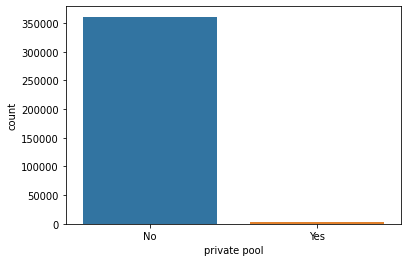

In [22]:
sns.countplot(x='private pool', data=df)

В результате мы имеем несбалансированный бинарный признак. Удалим его.

In [23]:
df.drop('private pool', axis = 1, inplace = True)

## 2. propertyType

- тип недвижимости; тип данных - **object**

In [24]:
df.propertyType.nunique()

1266

In [25]:
df.propertyType.isna().sum()

34591

Столбец имеет 1266 уникальных значений и 34591 пропуск. Так как пропусков достаточно много, заполним их значением 'no info', означающее отсутствие информации о типе нежвижимости.

In [26]:
df.propertyType = df.propertyType.fillna('no info')
df.propertyType.value_counts()[:50]

single-family home                  91806
Single Family                       60255
no info                             34591
Single Family Home                  26616
condo                               25918
lot/land                            20541
Condo                               16264
townhouse                           11398
Land                                10558
multi-family                         7750
Townhouse                            6838
Condo/Townhome/Row Home/Co-Op        6089
Traditional                          5902
coop                                 3266
Multi Family                         2741
High Rise                            1823
Ranch                                1767
mobile/manufactured                  1615
Detached, One Story                  1612
Single Detached, Traditional         1576
Contemporary                         1547
Multi-Family Home                    1245
Colonial                             1156
1 Story                           

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [27]:
df['propertyType'] = df['propertyType'].apply(lambda x: str(x).lower())
df.propertyType.value_counts()[:50]

single-family home                     91806
single family                          60255
condo                                  42182
no info                                34591
single family home                     26616
lot/land                               20541
townhouse                              18236
land                                   10558
multi-family                            7771
condo/townhome/row home/co-op           6089
traditional                             5902
coop                                    3266
multi family                            2741
high rise                               1823
ranch                                   1767
mobile/manufactured                     1615
detached, one story                     1612
single detached, traditional            1576
contemporary                            1547
multi-family home                       1245
colonial                                1156
1 story                                 1073
mobile / m

Приведём к единообразию некоторые значения.

In [28]:
df['propertyType'] = df['propertyType'].apply(lambda x: 'single-family' if (x=='single family') | (x=='single family home') |
                                             (x == 'single-family home') else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'multi-family' if (x=='multi family') | (x == 'multi-family home') else x)
df['propertyType'] = df['propertyType'].apply(lambda x: '1 story' if x=='one story' else x)
df['propertyType'] = df['propertyType'].apply(lambda x: '2 stories' if (x=='2 story') | (x=='two story')  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'land' if x=='lot/land'  else x)

In [29]:
df.propertyType.value_counts()[:50]

single-family                           178677
condo                                    42182
no info                                  34591
land                                     31099
townhouse                                18236
multi-family                             11757
condo/townhome/row home/co-op             6089
traditional                               5902
coop                                      3266
high rise                                 1823
ranch                                     1767
1 story                                   1665
mobile/manufactured                       1615
detached, one story                       1612
single detached, traditional              1576
contemporary                              1547
2 stories                                 1338
colonial                                  1156
mobile / manufactured                     1040
contemporary/modern                        998
apartment                                  887
single detach

In [30]:
propertyTypes_with_freqs = list(df.propertyType.value_counts())
top_propertyTypes_count = int(np.percentile(propertyTypes_with_freqs, 76))
top_propertyTypes_count

6

Выделим 6 самых популярных значений, которые описывают около 76% примеров - это single-family, condo, propertyType no info, land, townhouse, multi-family. Оставим только эти значения, остальные удалим.

In [31]:
all_propertyTypes = set(df.propertyType.value_counts().index)
main_propertyTypes = set(df.propertyType.value_counts().index[:6])
propertyTypes_to_drop = list(all_propertyTypes - main_propertyTypes)
df.drop(df.loc[df['propertyType'].isin(propertyTypes_to_drop), 'propertyType'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

In [32]:
cat_cols.append('propertyType')

## 3. street

- адрес; тип данных - **object**

In [33]:
df.street.nunique()

279370

In [34]:
df.street.isna().sum()

2

В столбце имеется 249390 уникальных значений и 1 пропуск. Посмотрим на значения.

In [35]:
df.street.loc[:10]

0           240 Heather Ln
1        12911 E Heroy Ave
2        2005 Westridge Rd
3      4311 Livingston Ave
4           1524 Kiscoe St
5        1624 S Newkirk St
6          6094 Mingle Dr 
7            11182 Owl Ave
8     8612 Cedar Plains Ln
9         16373 NW 16th St
10          1538 Umpqua Dr
Name: street, dtype: object

Из данного признака можно было бы извлечь расстояние между домом и центром города, в котором находится дом, но мы этого делать не будем. Поэтому удалим этот столбец.

In [36]:
df.drop('street', axis = 1, inplace = True)

## 4. baths

- количество и тип ванных комнат; тип данных - **object**

In [37]:
df.baths.nunique()

225

In [38]:
df.baths.isna().sum()

77101

В столбце 225 уникальных значений и 77101 пропуск.

In [39]:
df.baths.value_counts()[:50]

2 Baths         50166
3 Baths         35179
2.0             15778
2               15468
4 Baths         14651
3.0             10676
3                8810
Bathrooms: 2     8390
Bathrooms: 3     6196
1.0              5581
5 Baths          5321
2.5              5023
4.0              4542
2.5 Baths        4420
1                4204
0                3676
4                3308
Bathrooms: 1     2769
6 Baths          2573
2 ba             2533
3.5              2385
Bathrooms: 4     2276
3 ba             1858
3.5 Baths        1792
5.0              1542
7 Baths          1196
5                1163
1,500            1053
1.5              1036
Bathrooms: 5      806
4.5               796
3,000             793
6.0               731
4 ba              725
1 ba              702
8 Baths           631
2,000             605
1,250             604
1,750             585
1,000             510
6                 485
2,250             455
-- baths          402
4.5 Baths         373
7.0               362
Bathrooms:

Посмотрим на все уникальные значения.

In [40]:
df.baths.unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '7 Baths', '1,000', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '5.5 Baths', '1.0', '5 Baths', '1.5',
       '4', '2.5', '3.5 Baths', '2,000', '3,000', '8.0', '1 ba', '3.5 ba',
       '0', '5.0', '1,500', '7.0', '9 Baths', '2,250', '6.0', '12 Baths',
       '5.5', '1.5 Baths', '~', '1,250', 'Bathrooms: 6', '4.5 Baths',
       '5.5+', '6', '10 Baths', '6 ba', '2,750', 'Bathrooms: 19', '10.0',
       '1.5 ba', '4 ba', '12 ba', '8', '7.5+', '750', 'Bathrooms: 10',
       '2.5+', '0 / 0', 'Sq. Ft. ', '5 ba', '2,500', '18 Baths',
       '-- baths', 'Bathrooms: 7', '7', '18', '3.5+', '11 Baths',
       '1.75 Baths', '9', '12.0', '1.1 Baths', '6.5', 'Bathrooms: 8',
       '3,500', '4.5+', '5,000', '10', '19 Baths', 'Bathrooms: 9',
       '16 Baths', '1.5+', '1

Преобразуем данный признак в числовой. Он будет содержать количество полных ванных комнат в доме. Для этого сначала обработаем пропуски и значения '-- baths', '—', 'Sq. Ft. ', '~', которые не содержат цифр и фактически означают пропущенные значения. Заменим эти значения на '1000', и пропуски так же заполним значением '1000'. Затем удалим непонятные значения, представленные в малом количестве, такие как: '2-1 / 2-1 / 1-1 / 1-1', '1 / 1-0 / 1-0 / 1-0', '1 / 1 / 1 / 1', '3-1 / 2-2', 'Bathrooms: SemiMod', 'Bathrooms: 241', '1-0 / 1-0 / 1', '116 / 116 / 116', '750'.

In [41]:
df['baths'] = df['baths'].fillna('1000')

df['baths'] = df['baths'].apply(lambda x: '1000' if (x=='-- baths') | (x=='—') | (x=='Sq. Ft. ') | (x=='~') else x)
df = df.drop(df[(df.baths=='2-1 / 2-1 / 1-1 / 1-1') | (df.baths=='1 / 1-0 / 1-0 / 1-0') | (df.baths=='1 / 1 / 1 / 1') | \
                (df.baths=='3-1 / 2-2') | (df.baths=='Bathrooms: SemiMod') | (df.baths=='Bathrooms: 241') | \
                (df.baths=='1-0 / 1-0 / 1') | (df.baths=='116 / 116 / 116') | (df.baths=='750')].index)

df.reset_index(inplace = True, drop = True)

In [42]:
df.baths.unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', '1000', '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '7 Baths', '1,000', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '5.5 Baths', '1.0', '5 Baths', '1.5',
       '4', '2.5', '3.5 Baths', '2,000', '3,000', '8.0', '1 ba', '3.5 ba',
       '0', '5.0', '1,500', '7.0', '9 Baths', '2,250', '6.0', '12 Baths',
       '5.5', '1.5 Baths', '1,250', 'Bathrooms: 6', '4.5 Baths', '5.5+',
       '6', '10 Baths', '6 ba', '2,750', 'Bathrooms: 19', '10.0',
       '1.5 ba', '4 ba', '12 ba', '8', '7.5+', 'Bathrooms: 10', '2.5+',
       '0 / 0', '5 ba', '2,500', '18 Baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '11 Baths', '1.75 Baths', '9', '12.0', '1.1 Baths', '6.5',
       'Bathrooms: 8', '3,500', '4.5+', '5,000', '10', '19 Baths',
       'Bathrooms: 9', '16 Baths', '1.5+', '13 Baths', 'Bathrooms: 13',
       '14', 

Теперь создадим признак **full_baths**, содержащий количество полных ванных комнат в доме.

In [43]:
pattern = re.compile('\d+')
df['full_baths'] = df['baths'].apply(lambda x: int(pattern.findall(x)[0]))

In [44]:
df.full_baths.value_counts().index.sort_values()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
              11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
              22,   23,   24,   25,   26,   27,   28,   29,   30,   32,   34,
              35,   36,   39,   40,   41,   42,   43,   44,   55,   60,   64,
              68,   76, 1000],
           dtype='int64')

Данный столбец можно сделать категориальным, разбив количество ванных комнат на диапазоны, а отсутствие значения закодировать значением 'no_info'.

In [45]:
for i in df.index:
    if df['full_baths'].loc[i] == 0:
        df['full_baths'].loc[i] = 'no'
    elif df['full_baths'].loc[i]  == 1:
        df['full_baths'].loc[i] = '1'
    elif df['full_baths'].loc[i] == 2:
        df['full_baths'].loc[i] = '2'
    elif (df['full_baths'].loc[i] > 2) & (df['full_baths'].loc[i] < 1000):
        df['full_baths'].loc[i] = 'more_than_2'
    elif df['full_baths'].loc[i] == 1000:
        df['full_baths'].loc[i] = 'no_info'

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\2536809591.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_baths'].loc[i] = 'more_than_2'


Столбец **baths** удалим.

In [46]:
df.drop('baths', axis = 1, inplace = True)

In [47]:
cat_cols.append('full_baths')

## 5. homeFacts

- характеристики дома; тип данных - **object**

In [48]:
df.homeFacts.nunique()

264366

In [49]:
df.homeFacts.isna().sum()

0

In [50]:
df.homeFacts[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

В столбце типом данных является строка, в которой закодирован словарь. Применим функцию eval для раскодировки словаря.

In [51]:
df.homeFacts = df.homeFacts.apply(eval)

In [52]:
df.homeFacts[0]

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

1. Извлечем из словаря год постройки дома и создадим новый признак **'year_built'**.

In [53]:
df['year_built'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])

In [54]:
df.year_built.nunique()

223

In [55]:
df.year_built.isna().sum()

3578

In [56]:
df.year_built.unique()

array(['2019', '1961', '2006', '', '1920', '1976', '1970', '1996', '1982',
       '2008', '1899', '2016', '1954', '1989', '2014', '1915', '1994',
       '1923', '1960', '1977', '1972', '1963', '1981', '1949', '1930',
       '1991', '1958', '2005', '2017', '2018', '1983', '1928', '1997',
       '1964', '1974', '1940', '1965', '1973', '1968', '1999', '1918',
       '2007', '1984', '1946', '2003', '2000', '2004', '2002', '1947',
       '1957', '1967', '1969', '1975', '1988', '1955', '1950', '1959',
       '2012', '1924', '1956', '1966', '1992', '2001', '1985', '1971',
       '1909', '1953', '1993', '1990', '1995', '1998', '1980', '1951',
       '1907', '1885', '1941', '2010', '1927', '1929', '1978', '1901',
       None, '1922', '1906', '1945', '2009', '1962', '1979', '2011',
       '2015', '1897', '1987', '2020', '1926', '1952', '1925', '1910',
       '2013', '1986', '1943', '1935', '1890', '1900', '1895', '1911',
       '1948', 'No Data', '1942', '1944', '1916', '1893', '1879', '1914',
 

Столбец содержит 223 уникальных значения и 3578 пропусков. Видны некорректные значения. Проведем обработку этих данных. В столбце есть строки со значениями 559990649990 и 1. Удалим их.

In [57]:
df = df.drop(df[(df.year_built == '559990649990') | (df.year_built == '1')].index)
df.reset_index(inplace = True, drop = True)

Пустая строка ' ' означает пропуск, также пропуск означает строка 'No Data' и значение None. Сначала заменим ' ' и 'No Data' на None.

In [58]:
df.year_built = df.year_built.apply(lambda x: None if (x == '') | (x == 'No Data') else x)

In [59]:
df.year_built.unique()

array(['2019', '1961', '2006', None, '1920', '1976', '1970', '1996',
       '1982', '2008', '1899', '2016', '1954', '1989', '2014', '1915',
       '1994', '1923', '1960', '1977', '1972', '1963', '1981', '1949',
       '1930', '1991', '1958', '2005', '2017', '2018', '1983', '1928',
       '1997', '1964', '1974', '1940', '1965', '1973', '1968', '1999',
       '1918', '2007', '1984', '1946', '2003', '2000', '2004', '2002',
       '1947', '1957', '1967', '1969', '1975', '1988', '1955', '1950',
       '1959', '2012', '1924', '1956', '1966', '1992', '2001', '1985',
       '1971', '1909', '1953', '1993', '1990', '1995', '1998', '1980',
       '1951', '1907', '1885', '1941', '2010', '1927', '1929', '1978',
       '1901', '1922', '1906', '1945', '2009', '1962', '1979', '2011',
       '2015', '1897', '1987', '2020', '1926', '1952', '1925', '1910',
       '2013', '1986', '1943', '1935', '1890', '1900', '1895', '1911',
       '1948', '1942', '1944', '1916', '1893', '1879', '1914', '1939',
       '

Переведём столбец в числовой формат.

In [60]:
df.year_built = df.year_built.apply(lambda x: int(x) if x != None else x)

In [61]:
type(df.year_built[0])

numpy.float64

Теперь посчитаем сколько у нас всего пропусков:

In [62]:
df.year_built.isna().sum()

61925

Таких значений 61925. Заполним их медианным значением, округлённым до целого.

In [63]:
round(df.year_built.median())

1985

In [64]:
df['year_built'] = df['year_built'].fillna(1985)

Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

In [65]:
df.year_built.loc[outliers_iqr(df.year_built)].sort_values()

144763    1057.0
221539    1060.0
2017      1700.0
145918    1703.0
267785    1703.0
           ...  
256813    1901.0
257021    1901.0
64306     1901.0
247154    1901.0
240654    1901.0
Name: year_built, Length: 5873, dtype: float64

Выявлено 5873 выброса. Удалим их.

In [66]:
df = df.drop(outliers_iqr(df.year_built))
df.reset_index(inplace = True, drop = True)

Посмотрим все ли значения соответствуют здравому смыслу. Для этого они не должны быть больше 2021 года.

In [67]:
len(df[df.year_built > 2021])

4

Выяснилось, что есть 4 таких значений. Также удалим их как выбросы.

In [68]:
df.drop(df[df.year_built > 2021].index, inplace = True)

df.reset_index(inplace = True, drop = True)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

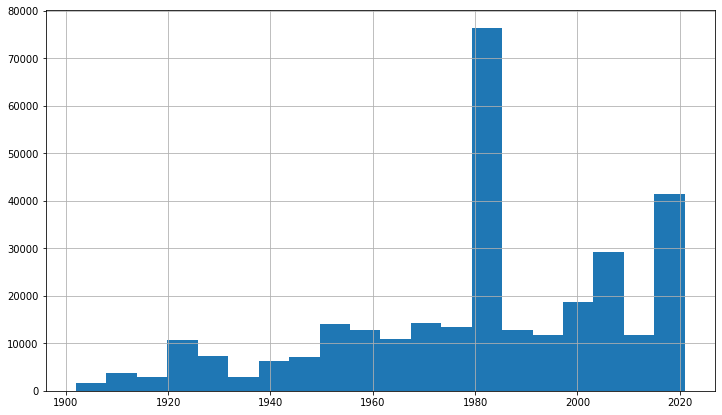

In [69]:
plt.figure(figsize = (12,7))
df.year_built.hist(bins=20)

Распределение имеет левый хвост.

In [70]:
num_cols.append('year_built')

2. Теперь извлечём из словаря год реконструкции дома и создадим еще один признак **remodeled_year**.

In [71]:
df['remodeled_year'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])

In [72]:
df.remodeled_year.nunique()

130

In [73]:
df.remodeled_year.isna().sum()

24846

In [74]:
df.remodeled_year.unique()

array(['', '1967', '2006', None, '1997', '2019', '1982', '2009', '1995',
       '1988', '1972', '1949', '1954', '1930', '2003', '2000', '1994',
       '2005', '1983', '1965', '1968', '1999', '2014', '2008', '2010',
       '2004', '2007', '2002', '1978', '1975', '1971', '1947', '1957',
       '1950', '1973', '1970', '1989', '1998', '1980', '1986', '1955',
       '1991', '1993', '2011', '1996', '2016', '1941', '2001', '1990',
       '1979', '1984', '1918', '1962', '1956', '2013', '1960', '1981',
       '1969', '1987', '1958', '1910', '1925', '2017', '1966', '1992',
       '1943', '1961', '2015', '1948', '1952', '1931', '1976', '1974',
       '1935', '1940', '1916', '1914', '1963', '2012', '2018', '1985',
       '1951', '1944', '1977', '1964', '1942', '1959', '1927', '1946',
       '1945', '1920', '1938', '1936', '0', '1939', '1915', '1928',
       '1923', '1929', '1934', '1953', '1926', '1937', '1912', '1917',
       '1899', '1932', '1905', '1919', '1901', '1906', '1921', '1924',
       

Столбец содержит 130 уникальных значений и 24846 пропусков. Проведем обработку этих данных. Предположим, что пустая строка ' ', '0' и пропуски означают то, что реконструкция дома не проводилась. Заменим пустую строку ' ' на '0'. Пропуски также заполним значением '0'.

In [75]:
df.remodeled_year = df.remodeled_year.apply(lambda x: '0' if x == '' else x)
df.remodeled_year = df.remodeled_year.fillna('0')

In [76]:
df.remodeled_year.unique()

array(['0', '1967', '2006', '1997', '2019', '1982', '2009', '1995',
       '1988', '1972', '1949', '1954', '1930', '2003', '2000', '1994',
       '2005', '1983', '1965', '1968', '1999', '2014', '2008', '2010',
       '2004', '2007', '2002', '1978', '1975', '1971', '1947', '1957',
       '1950', '1973', '1970', '1989', '1998', '1980', '1986', '1955',
       '1991', '1993', '2011', '1996', '2016', '1941', '2001', '1990',
       '1979', '1984', '1918', '1962', '1956', '2013', '1960', '1981',
       '1969', '1987', '1958', '1910', '1925', '2017', '1966', '1992',
       '1943', '1961', '2015', '1948', '1952', '1931', '1976', '1974',
       '1935', '1940', '1916', '1914', '1963', '2012', '2018', '1985',
       '1951', '1944', '1977', '1964', '1942', '1959', '1927', '1946',
       '1945', '1920', '1938', '1936', '1939', '1915', '1928', '1923',
       '1929', '1934', '1953', '1926', '1937', '1912', '1917', '1899',
       '1932', '1905', '1919', '1901', '1906', '1921', '1924', '1907',
       '1

Переведем столбец в числовой формат.

In [77]:
df.remodeled_year = df.remodeled_year.apply(lambda x: int(x))

In [78]:
type(df.remodeled_year[0])

numpy.int64

Посмотрим сколько нулевых значений в столбце.

In [79]:
len(df[df.remodeled_year == 0])

185220

Количество нулей в столбце 185220, это 2/3 всех данных в столбце. Целесообразно данный столбец закодировать в бинарный признак, где нули заменим на значение 'no', которое будет означать то, что реконструкция дома не проводилась, а значения годов заменим на 'yes', что будет означать проведение реконструкции.

Создаём новый столбец remodeling.

In [80]:
df['remodeling'] = df.remodeled_year.apply(lambda x: 'yes' if x > 0 else 'no')
df.drop('remodeled_year', axis = 1, inplace = True)

In [81]:
df.remodeling.value_counts()

no     185220
yes    125387
Name: remodeling, dtype: int64

Посмотрим на гистограмму распределения признака.

<AxesSubplot:xlabel='remodeling', ylabel='count'>

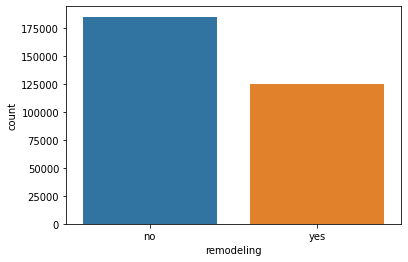

In [82]:
sns.countplot(x = 'remodeling', data = df)

Признак можно считать сбалансированным.

In [83]:
bin_cols.append('remodeling')

3. Следующий признак, который заключен в словаре - это Heating (отопление). Извлечем его в соответствующий столбец **heating**.

In [84]:
df['heating'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])

In [85]:
df.heating.nunique()

1197

In [86]:
df.heating.isna().sum()

3529

In [87]:
df.heating.value_counts()[:50]

                                         84099
Forced Air                               78366
Forced air                               48732
Other                                    27443
Electric                                  9404
Gas                                       8325
No Data                                   7754
Heat Pump                                 5738
Central                                   4178
Baseboard                                 3259
Wall                                      3049
Central, Electric                         2686
Heat pump                                 2569
Central Air                               2087
Central Electric                          1881
Forced air, Heat pump                     1672
Heating System                            1527
Radiant                                   1217
Electric Heat                              880
Gas Heat                                   647
Central Furnace                            568
Forced Air, N

В столбце имеется 1197 уникальных записей и 3529 пропусков. Здесь целесообразно заполнить пропуски значением 'no info', которое будет означать отсутствие информации об отоплении дома.

In [88]:
df['heating'] = df['heating'].fillna('no info')

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [89]:
df['heating'] = df['heating'].apply(lambda x: str(x).lower())
df.heating.value_counts()[:50]

forced air                               127098
                                          84099
other                                     27443
electric                                   9404
gas                                        8325
heat pump                                  8307
no data                                    7754
central                                    4178
no info                                    3529
baseboard                                  3259
wall                                       3049
central, electric                          2686
central air                                2087
central electric                           1881
forced air, heat pump                      1687
heating system                             1527
radiant                                    1217
electric heat                               880
gas heat                                    647
central furnace                             568
forced air, natural gas                 

Заменим пустую строку ' ' и значение 'no data' на значение 'no info'. Также значения 'central air', 'forced air heating' и 'central air, ceiling fan(s)' заменим на 'forced air', значения 'central electric', 'electric heat', 'central, electric' и 'central electric, zoned' на 'electric', значения 'natural gas heat', 'gas heat', 'natural gas', 'central gas' и 'central, gas' на 'gas', значение ', heat pump - heat' и 'central, heat pump' на 'heat pump'.

In [90]:
df['heating'] = df['heating'].apply(lambda x: 'no info' if (x == '') | (x == 'no data') else x)
df['heating'] = df['heating'].apply(lambda x: 'forced air' if (x == 'central air') | (x == 'forced air heating') else x)
df['heating'] = df['heating'].apply(lambda x: 'electric' if (x == 'central electric') | (x == 'electric heat') | 
                                    (x == 'central, electric') | (x == 'central air, ceiling fan(s)') | 
                                    (x == 'central electric, zoned') else x)
df['heating'] = df['heating'].apply(lambda x: 'gas' if (x == 'natural gas heat') | (x == 'gas heat') | (x == 'natural gas') |
                                    (x == 'central gas') | (x == 'central, gas') else x)
df['heating'] = df['heating'].apply(lambda x: 'heat pump' if (x == ', heat pump - heat') | (x == 'central, heat pump') else x)

In [91]:
df.heating.value_counts()[:50]

forced air                               129471
no info                                   95382
other                                     27443
electric                                  15151
gas                                        9738
heat pump                                  8652
central                                    4178
baseboard                                  3259
wall                                       3049
forced air, heat pump                      1687
heating system                             1527
radiant                                    1217
central furnace                             568
forced air, natural gas                     403
central electric, heat pump                 387
, gas hot air/furnace                       376
central heating                             344
electric, gas                               325
forced air, other                           307
forced air, gas                             249
forced air, stove                       

In [92]:
heatingTypes_with_freqs = list(df.heating.value_counts())
top_heatingTypes_count = int(np.percentile(heatingTypes_with_freqs, 83))
top_heatingTypes_count

6

Определим 6 самых популярных значений, которые описывают около 83% примеров - это forced air, no info, other, electric, gas, heat pump. Оставим только эти значения, остальные удалим.

In [93]:
all_heatingTypes = set(df.heating.value_counts().index)
main_heatingTypes = set(df.heating.value_counts().index[:6])
heatingTypes_to_drop = list(all_heatingTypes - main_heatingTypes)
df.drop(df.loc[df['heating'].isin(heatingTypes_to_drop), 'heating'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

In [94]:
cat_cols.append('heating')

4. Извлечем следующий признак из столбца homeFacts - **cooling** (охлаждение).

In [95]:
df['cooling'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])

In [96]:
df.cooling.nunique()

424

In [97]:
df.cooling.isna().sum()

3529

In [98]:
df.cooling.value_counts()[:50]

Central                                                        147046
                                                                98691
No Data                                                          8775
None                                                             4987
Central Air                                                      4688
Central Electric                                                 3503
Has Cooling                                                      2323
Wall                                                             2225
Other                                                            1400
Refrigeration                                                     829
Evaporative                                                       812
Central, Electric                                                 782
Refrigeration, Ceiling Fan(s)                                     565
Central, Wall                                                     561
Solar, Refrigeration

В столбце имеется 424 уникальных записи и 3529 пропусков. Здесь целесообразно заполнить пропуски значением 'no info', которое будет означать отсутствие информации о системе охлаждения в доме.

In [99]:
df['cooling'] = df['cooling'].fillna('no info')

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [100]:
df['cooling'] = df['cooling'].apply(lambda x: str(x).lower())
df.cooling.value_counts()[:50]

central                                                        147046
                                                                98691
no data                                                          8775
none                                                             4987
central air                                                      4688
no info                                                          3529
central electric                                                 3503
has cooling                                                      2323
wall                                                             2225
other                                                            1400
refrigeration                                                     829
evaporative                                                       812
central, electric                                                 782
refrigeration, ceiling fan(s)                                     565
central, wall       

Столбец содержит слишком грязные данные, поэтому удалим его.

In [101]:
df.drop('cooling', axis = 1, inplace = True)

5. Следующий признак, который мы можем извлечь из столбца homeFacts - это **parking** (парковка автомобиля).

In [102]:
df['parking'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])

In [103]:
df.parking.nunique()

1303

In [104]:
df.parking.isna().sum()

3529

In [105]:
df.parking.value_counts()[:50]

                                             113114
Attached Garage                               67054
2 spaces                                      25331
1 space                                       12192
Detached Garage                               11311
No Data                                       11204
Carport                                        6706
3 spaces                                       4177
Off Street                                     2977
Carport, Attached Garage                       2773
4 spaces                                       2506
1                                              2270
2                                              1993
None                                           1779
Off street                                     1340
Attached Garage, Detached Garage               1221
Attached Garage, Carport                        918
Parking Desc                                    819
Detached Garage, Attached Garage                684
On Street   

В столбце имеется 1303 уникальных записи и 3529 пропусков. Здесь целесообразно заполнить пропуски значением 'no info', которое будет означать отсутствие информации о парковке.

In [106]:
df['parking'] = df['parking'].fillna('no info')
df.parking.value_counts()[:50]

                                             113114
Attached Garage                               67054
2 spaces                                      25331
1 space                                       12192
Detached Garage                               11311
No Data                                       11204
Carport                                        6706
3 spaces                                       4177
no info                                        3529
Off Street                                     2977
Carport, Attached Garage                       2773
4 spaces                                       2506
1                                              2270
2                                              1993
None                                           1779
Off street                                     1340
Attached Garage, Detached Garage               1221
Attached Garage, Carport                        918
Parking Desc                                    819
Detached Gar

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [107]:
df['parking'] = df['parking'].apply(lambda x: str(x).lower())
df.parking.value_counts()[:50]

                                             113114
attached garage                               67054
2 spaces                                      25331
1 space                                       12192
detached garage                               11311
no data                                       11204
carport                                        6706
off street                                     4317
3 spaces                                       4177
no info                                        3529
carport, attached garage                       2773
4 spaces                                       2506
1                                              2270
2                                              1993
none                                           1779
attached garage, detached garage               1221
on street                                       929
attached garage, carport                        918
parking desc                                    819
detached gar

Заменим значения ' ', 'no data', и 'none' на 'no_info', значения 'drvwy' и 'driveway paved' на 'driveway', значение '1' на '1_space', значение '2' на '2_spaces', значения 'carport', 'off street', 'off street parking', 'on street', 'driveway' на 'other'.

In [108]:
df['parking'] = df['parking'].apply(lambda x: 'no_info' if (x == '') | (x == 'no data') | (x == 'none') else x)
df['parking'] = df['parking'].apply(lambda x: '1_space' if (x == '1') else x)
df['parking'] = df['parking'].apply(lambda x: '2_spaces' if (x == '2') else x)
df['parking'] = df['parking'].apply(lambda x: 'other' if (x == 'carport') | (x == 'off street') | (x == 'off street parking') | 
                                    (x == 'on street') | (x == 'driveway') | (x == 'drvwy') | (x == 'driveway paved') else x)

Заменим значения, где количество парковочных мест больше двух, на значение 'more_than_2_spaces'.

In [109]:
pattern = re.compile('\d+')

# Создаём вспомогательный столбец 'n_spaces', в который запишем количество парковочных мест
df['n_spaces'] = df['parking'].apply(lambda x: int(pattern.findall(x)[0]) if len(pattern.findall(x)) > 0 else 0)

# Основываясь на информации в столбце 'n spaces' запишем значение 'more_than_2_spaces' в столбец parking там где количество 
# парковочных мест больше двух
for i in df.index:
    if df['n_spaces'].loc[i] > 2:
        df['parking'].loc[i] = 'more_than_2_spaces'
    else:
        continue

# Удалим столбец 'n spaces'
df.drop('n_spaces', axis = 1, inplace = True)

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\297012036.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parking'].loc[i] = 'more_than_2_spaces'


In [110]:
df.parking.value_counts()[:50]

no_info                                                            126097
attached garage                                                     67054
2 spaces                                                            25331
other                                                               12650
1 space                                                             12192
detached garage                                                     11311
more_than_2_spaces                                                   9975
no info                                                              3529
carport, attached garage                                             2773
1_space                                                              2270
2_spaces                                                             1993
attached garage, detached garage                                     1221
attached garage, carport                                              918
parking desc                          

In [111]:
parkingTypes_with_freqs = list(df.parking.value_counts())
top_parkingTypes_count = int(np.percentile(parkingTypes_with_freqs, 89))
top_parkingTypes_count

7

Определим 7 самых популярных значений, которые описывают около 89% примеров - это no_info, attached garage, detached garage, 1_space, 2_spaces, more_than_2_spaces, other. Оставим только эти значения, остальные удалим.

In [112]:
all_parkingTypes = set(df.parking.value_counts().index)
main_parkingTypes = set(df.parking.value_counts().index[:7])
parkingTypes_to_drop = list(all_parkingTypes - main_parkingTypes)
df.drop(df.loc[df['parking'].isin(parkingTypes_to_drop), 'parking'].index, inplace = True)

df.reset_index(inplace = True, drop = True)

In [113]:
cat_cols.append('parking')

6. Следующий признак, который заключен в столбце homeFacts - это lotsize (площадь земельного участка).

In [114]:
df['lotsize'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])

In [115]:
df.lotsize.nunique()

26529

In [116]:
df.lotsize.isna().sum()

16400

In [117]:
df.lotsize.value_counts()[:50]

               27149
—              13365
No Data         5113
-- sqft lot     3154
0.26 acres      2210
0.25 acres      2075
0.28 acres      1850
0.27 acres      1703
0.29 acres      1682
0.34 acres      1383
0.3 acres       1266
6,098 sqft      1263
10,000 sqft     1180
0.31 acres      1171
7,405 sqft      1117
0.32 acres      1100
6,534 sqft      1079
4,356 sqft      1077
5,227 sqft       999
0.33 acres       955
0.35 acres       954
5,000 sqft       916
0.36 acres       860
8,712 sqft       857
0.46 acres       831
8,276 sqft       831
3,920 sqft       808
0.37 acres       787
10,019 sqft      775
0.5 acres        765
0.38 acres       701
10000            670
0.39 acres       665
1 acre           660
0.4 acres        636
9,583 sqft       633
4,792 sqft       633
0.41 acres       630
10,454 sqft      620
4,791 sqft       613
10019            566
7,840 sqft       556
0.42 acres       554
3,049 sqft       537
0.43 acres       531
6,969 sqft       525
10018 sqft       523
0.44 acres   

В столбце присутствует 26740 уникальных значений и 19929 пропусков. Преобразуем столбец в числовой тип данных и заполним пропуски и значения, которые будем считать пропусками, медианой. Пропусками также будем считать значения ' ', '—', 'No Data' и '-- sqft lot'. Сначала отфильтруем пропуски и все значения, которые считаем пропусками, затем преобразуем столбец в числовой формат, переведём все значения в квадратные метры (m^2) и посчитаем среднее арифметическое.

In [118]:
pattern = re.compile('\d+[.]?[,]?\d+')

# Фильтруем все значения, которые считаем пропусками
sub_df = df[(df.lotsize != '') & (df.lotsize != '—') & (df.lotsize != 'No Data') & (df.lotsize != '-- sqft lot') & \
            (pd.isna(df.lotsize) != True)]

# Выделяем числовые значения
for i in sub_df.index:
    if len(pattern.findall(sub_df.lotsize.loc[i])) != 0:
        sub_df['lotsize'].loc[i] = pattern.findall(sub_df.lotsize.loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

# Убираем запятые
sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: float(x))

# Приводим всё к размерности [кв.м.]
sub_df['lotsize'] = sub_df['lotsize'].apply(lambda x: round(x/10.764) if x > 1 else round(x*4047))

# Считаем среднее в квадратных метрах и переводим в квадратные футы
round(sub_df['lotsize'].median()*10.764)

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\4093142037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['lotsize'].loc[i] = pattern.findall(sub_df.lotsize.loc[i])[0]
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\4093142037.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop(i, axis = 0, inplace = True)
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\4093142037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

7406

Теперь в исходном датафрейме df заменим пропуски и значения ' ', '—', 'No Data' и '-- sqft lot' на значение '7406'.

In [119]:
df['lotsize'] = df['lotsize'].apply(lambda x: '7406' if (x=='') | (x=='—') | (x=='No Data') | (x=='-- sqft lot') | \
                                    (pd.isna(x) == True) else x)

Снова проделаем те же операции со столбцом, что и в датафрейме sub_df для того, чтобы получить числовой формат с размерностью m^2.

In [120]:
pattern = re.compile('\d+[.]?[,]?\d+')

# Выделяем цифровые значения
df['lotsize'] = df['lotsize'].apply(lambda x: '7406' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

# Убираем запятые
df['lotsize'] = df['lotsize'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
df['lotsize'] = df['lotsize'].apply(lambda x: float(x))

# Приводим всё к размерности [кв.м.]
df['lotsize'] = df['lotsize'].apply(lambda x: round(x/10.764) if x > 1 else round(x*4047))

Посмотрим на гистограмму распределения признака:

<AxesSubplot:>

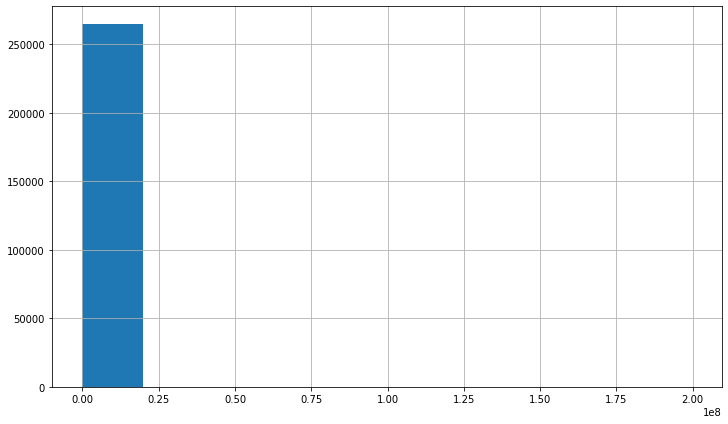

In [121]:
plt.figure(figsize = (12,7))
df.lotsize.hist()

Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

In [122]:
df.lotsize.loc[outliers_iqr(df.lotsize)].sort_values()

116671         1578
116924         1578
45480          1578
45504          1578
45653          1578
            ...    
56725       5544147
214325     26441940
29464      40541070
111694    172754816
46016     199506099
Name: lotsize, Length: 27144, dtype: int64

Выявлено 28342 выброса. Удалим их.

In [123]:
df.drop(outliers_iqr(df.lotsize), inplace = True)
df.reset_index(inplace = True, drop = True)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

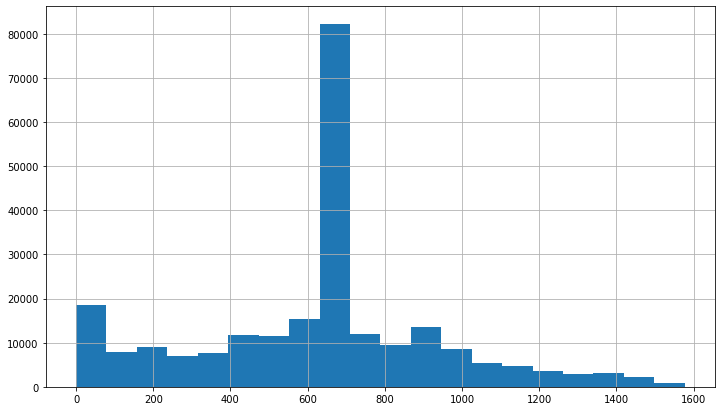

In [124]:
plt.figure(figsize = (12,7))
df.lotsize.hist(bins=20)

In [125]:
num_cols.append('lotsize')

7. Последний признак, который заключен в столбце homeFacts - это Price/sqft (цена 1 квадратного фута земли). Извлечем его.

In [126]:
df['price/sqft'] = df['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

In [127]:
df['price/sqft'].nunique()

5473

In [128]:
df['price/sqft'].isna().sum()

39246

In [129]:
df['price/sqft'].value_counts()[:50]

             2330
No Data       954
$115/sqft     664
$125/sqft     662
$132/sqft     650
$1/sqft       639
$119/sqft     632
$117/sqft     628
$139/sqft     626
$121/sqft     625
$120/sqft     624
$128/sqft     623
$122/sqft     621
$130/sqft     618
$127/sqft     615
$116/sqft     610
$140/sqft     606
$124/sqft     606
$136/sqft     605
$133/sqft     605
$123/sqft     602
$118/sqft     601
$134/sqft     601
$135/sqft     595
$114/sqft     594
$131/sqft     591
$141/sqft     590
$126/sqft     589
$113/sqft     587
$129/sqft     587
$138/sqft     582
$110/sqft     579
$143/sqft     574
$111/sqft     572
$146/sqft     572
$137/sqft     563
$148/sqft     560
$145/sqft     557
$150/sqft     551
$100/sqft     548
$142/sqft     546
$108/sqft     545
$147/sqft     540
$109/sqft     538
$107/sqft     527
$149/sqft     526
$112/sqft     525
$105/sqft     520
$144/sqft     520
$152/sqft     517
Name: price/sqft, dtype: int64

В столбце присутствует 5519 уникальных значений и 42731 пропуск. Преобразуем столбец в числовой тип данных и заполним пропуски и значения, которые будем считать пропусками, медианой. Пропусками также будем считать значения ' ', 'No Data' и 'No Info'. Сначала отфильтруем пропуски и все значения, которые считаем пропусками, затем преобразуем столбец в числовой формат. Цена приведена в расчете на 1 кв. фут, но у нас площадь участков в кв. метрах. Значит нужно будет перевести цены в расчете на 1 кв. метр. Для этого нужно умножить их на 10,764. Новые значения запишем в столбец price/sqm.

In [130]:
pattern = re.compile('\d+[.]?[,]?\d+')

# Фильтруем все значения, которые считаем пропусками
sub_df = df[(df['price/sqft'] != '') & (df['price/sqft'] != 'No Data') & (df['price/sqft'] != 'No Info') & \
            (pd.isna(df['price/sqft']) != True)]

# Выделяем числовые значения
for i in sub_df.index:
    if len(pattern.findall(sub_df['price/sqft'].loc[i])) != 0:
        sub_df['price/sqft'].loc[i] = pattern.findall(sub_df['price/sqft'].loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

# Убираем запятые
sub_df['price/sqft'] = sub_df['price/sqft'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
sub_df['price/sqft'] = sub_df['price/sqft'].apply(lambda x: int(x))

# Считаем среднее арифметическое
round(sub_df['price/sqft'].median())

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\701493753.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['price/sqft'].loc[i] = pattern.findall(sub_df['price/sqft'].loc[i])[0]


C:\Users\anton\AppData\Local\Temp\ipykernel_13064\701493753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop(i, axis = 0, inplace = True)
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\701493753.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['price/sqft'].loc[i] = pattern.findall(sub_df['price/sqft'].loc[i])[0]
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\701493753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

175

Теперь в исходном датафрейме df заменим пропуски и значения ' ', 'No Data' и 'No Info' на значение '177'.

In [131]:
df['price/sqft'] = df['price/sqft'].apply(lambda x: '177' if (x == '') | (x == 'No Data') | (x == 'No Info') | \
                                          (pd.isna(x) == True) else x)

Снова проделаем те же операции со столбцом, что и в датафрейме sub_df для того, чтобы получить числовой формат с ценой за m^2.

In [132]:
pattern = re.compile('\d+[.]?[,]?\d+')

# Выделяем цифровые значения
df['price/sqft'] = df['price/sqft'].apply(lambda x: '177' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

# Убираем запятые
df['price/sqft'] = df['price/sqft'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
df['price/sqft'] = df['price/sqft'].apply(lambda x: int(x))

#Переводим цены за кв. фут в цены за кв. м.
df['price/sqm'] = df['price/sqft'].apply(lambda x: round(x*10.764))

Стобец price/sqft нам больше не нужен, поэтому удалим его.

In [133]:
df.drop('price/sqft', axis = 1, inplace = True)

Посмотрим на гистограмму распределения признака price/sqm.

<AxesSubplot:>

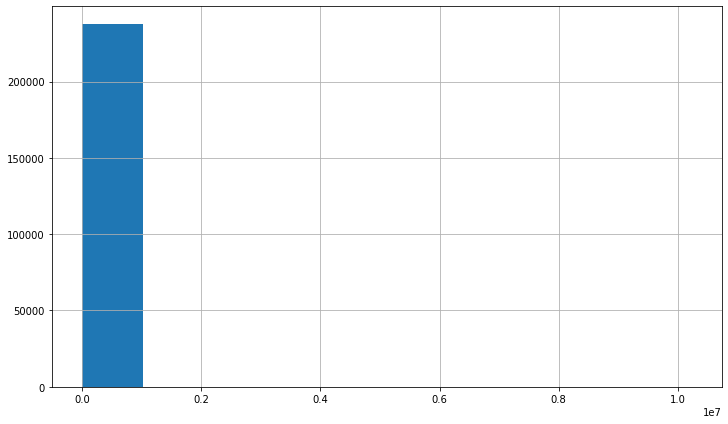

In [134]:
plt.figure(figsize = (12,7))
df['price/sqm'].hist()

Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

In [135]:
df['price/sqm'].loc[outliers_iqr(df['price/sqm'])].sort_values()

94848         4639
108666        4639
151179        4639
144352        4639
200821        4639
            ...   
26112      8503560
122833     9461556
136556     9666072
152279     9686524
39318     10225800
Name: price/sqm, Length: 27228, dtype: int64

Выявлено 25340 выбросов. Удалим их.

In [136]:
df.drop(outliers_iqr(df['price/sqm']), inplace = True)
df.reset_index(inplace = True, drop = True)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

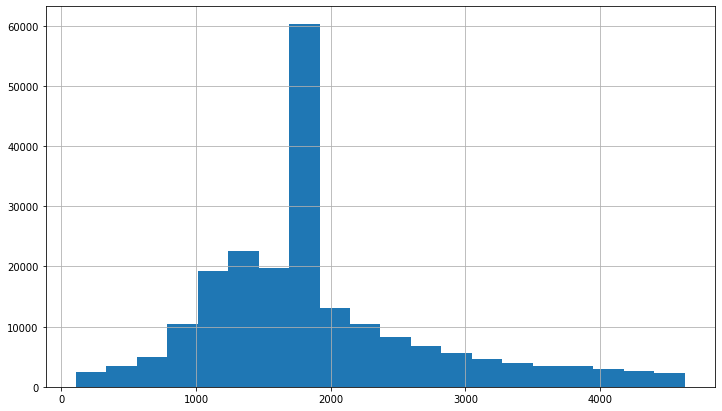

In [137]:
plt.figure(figsize = (12,7))
df['price/sqm'].hist(bins=20)

In [138]:
num_cols.append('price/sqm')

In [139]:
df.drop('homeFacts', axis = 1, inplace = True)

## 6. fireplace

- камин; тип данных - **object**

In [140]:
df.fireplace.nunique()

237

In [141]:
df.fireplace.isna().sum()

158595

In [142]:
df.fireplace.value_counts()[:50]

yes                                      32405
Yes                                      13330
1                                         2332
Not Applicable                            1677
2                                          400
No                                         234
Fireplace YN                               129
0                                          124
Gas/Gas Logs                                82
Living Room                                 67
1 Fireplace                                 55
Wood                                        45
3                                           43
Special Features                            40
Wood Burning                                38
Gas Logs, In Great Room                     29
Fireplace Features                          24
Family Room                                 22
Gas                                         20
Gas Logs, In Living Room                    20
Living Room, Wood Burning                   19
Family Room, 

В столбце содержится 238 уникальных значений и 164011 пропусков. Логично предположить, что здесь пропуск означает отсутствие камина. Поэтому целесообразно заполнить все пропуски значением 'no'.

In [143]:
df.fireplace = df.fireplace.fillna('no')

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [144]:
df['fireplace'] = df['fireplace'].apply(lambda x: str(x).lower())
df.fireplace.value_counts()[:50]

no                                                        158829
yes                                                        45735
1                                                           2332
not applicable                                              1677
2                                                            400
fireplace yn                                                 129
0                                                            124
gas/gas logs                                                  82
living room                                                   67
1 fireplace                                                   55
wood                                                          45
3                                                             43
special features                                              40
wood burning                                                  38
gas logs, in great room                                       29
fireplace features       

Заменим значение '0' на 'no'.

In [145]:
df['fireplace'] = df['fireplace'].apply(lambda x: 'no' if x=='0' else x)

Проведем бинарное кодирование столбца: заменим все значения, которые не равны 'no' на 'yes'.

In [146]:
df['fireplace'] = df['fireplace'].apply(lambda x: 'yes' if x!='no' else x)

In [147]:
bin_cols.append('fireplace')

## 7. city

- город; тип данных - **object**

In [148]:
df.city.nunique()

1560

In [149]:
df.city.isna().sum()

10

In [150]:
df.city.value_counts()[:50]

Houston             13523
San Antonio          9955
Miami                8072
Jacksonville         6348
Dallas               5153
Las Vegas            4756
Chicago              4370
Orlando              4217
New York             3971
Tampa                3874
Austin               3644
Fort Worth           3546
Philadelphia         3421
Fort Lauderdale      2890
Atlanta              2766
Palm Coast           2520
Detroit              2508
Charlotte            2501
Brooklyn             2239
Cleveland            2167
Saint Petersburg     2030
Lehigh Acres         1992
Indianapolis         1921
Memphis              1911
El Paso              1833
Ocala                1764
Nashville            1763
Kissimmee            1710
Reno                 1450
Portland             1417
Port Charlotte       1292
Denver               1244
Cape Coral           1207
Raleigh              1172
Chattanooga          1081
Fresno               1081
Sacramento           1022
Washington            998
Hialeah     

Столбец имеет 1575 уникальных значений и 10 пропусков. Заполним пропуски самым популярным городом - это Houston.

In [151]:
df['city'] = df['city'].fillna('Houston')
df.city.value_counts()[:10]

Houston         13533
San Antonio      9955
Miami            8072
Jacksonville     6348
Dallas           5153
Las Vegas        4756
Chicago          4370
Orlando          4217
New York         3971
Tampa            3874
Name: city, dtype: int64

In [152]:
df.city.value_counts()[:10]

Houston         13533
San Antonio      9955
Miami            8072
Jacksonville     6348
Dallas           5153
Las Vegas        4756
Chicago          4370
Orlando          4217
New York         3971
Tampa            3874
Name: city, dtype: int64

In [153]:
cities_with_freqs = list(df.city.value_counts())
top_cities_count = int(np.percentile(cities_with_freqs, 50))
top_cities_count

8

Выделим 9 самых популярных городов, которые описывают около 50% примеров - это Houston, San Antonio, Miami, Jacksonville, Dallas, Las Vegas, Chicago, Orlando, Tampa, остальные назовём other.

In [154]:
all_cities = set(df.city.value_counts().index)
main_cities = set(df.city.value_counts().index[:9])
cities_to_drop = list(all_cities - main_cities)
df.loc[df['city'].isin(cities_to_drop), 'city'] = 'other'

In [155]:
cat_cols.append('city')

## 8. schools

- данные о близлежащих школах; тип данных - **object**

In [156]:
df.schools.nunique()

166973

In [157]:
df.schools.isna().sum()

0

Пропуски отсутствуют.

In [158]:
df.schools.loc[0]

"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"

В столбце типом данных является строка, в которой закодирован список. В списке в свою очередь заключен словарь. Применим функцию eval для раскодировки списка.

In [159]:
df.schools = df.schools.apply(eval)

In [160]:
df.schools.loc[0]

[{'rating': ['4/10', 'None/10', '4/10'],
  'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'],
   'Grades': ['9-12', '3-8', 'PK-8']},
  'name': ['East Valley High School&Extension',
   'Eastvalley Middle School',
   'Trentwood Elementary School']}]

Здесь содержатся данные о школах, расположенных рядом с домом, такие как: rating - рейтинги школ, Distance - расстояния до школ, Grades - возрастной уровень школ и name - названия школ. Из данного столбца можно создать такие признаки как: средний рейтинг школ - 'average_school_rating', количество рядом расположенных школ - 'number_of_schools' и среднее расстояние до школ - 'average_distance_to_school'. Извлечём данные.

1. Средний рейтинг школ - average_school_rating.

Извлечём показатели рейтингов школ в столбец average_school_rating.

In [161]:
df['average_school_rating'] = df['schools'].apply(lambda x: x[0]['rating'])

In [162]:
df['average_school_rating'].isna().sum()

0

Пропуски отсутствуют. Посмотрим на структуру данных.

In [163]:
for i in range(5):
    print(df['average_school_rating'].loc[i])

['4/10', 'None/10', '4/10']
['9/10', '9/10', '10/10', '9/10']
['4/10', '5/10', '5/10']
[]
['4', '2', '2']


Извлечём числовые показатели и посчитаем средний рейтинг.

In [164]:
pattern = re.compile('\d+')

for i in df.index:
    sum_ratings = 0
    count = 0
    for item in df['average_school_rating'].loc[i]:
        if (len(pattern.findall(item)) != 0) & ('None' not in item):
            sum_ratings += int(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        df['average_school_rating'].loc[i] = 0
    else:
        df['average_school_rating'].loc[i] = round(sum_ratings/count, 1)

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\2103671807.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['average_school_rating'].loc[i] = round(sum_ratings/count, 1)
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\2103671807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['average_school_rating'].loc[i] = 0


In [165]:
df['average_school_rating'].value_counts()

6.0    12581
4.0    11791
5.0    11218
3.0    10710
3.3     9548
       ...  
1.4        7
5.1        5
2.1        4
1.2        3
1.9        2
Name: average_school_rating, Length: 85, dtype: int64

Посмотрим сколько в столбце нулевых значений.

In [166]:
len(df[df['average_school_rating'] == 0])

2247

Нулевое значение подразумевает отсутствие информации о рейтингах школ. Таких значений 2285. Заменим нули медианным значением, округлённым до целого.

In [167]:
# Отфильтруем нули в столбце и посчитаем среднее
round(df[df['average_school_rating'] != 0]['average_school_rating'].median())

5

In [168]:
# Заменим средним арифметическим нулевые значения
df['average_school_rating'] = df['average_school_rating'].apply(lambda x: 5 if x == 0 else x)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

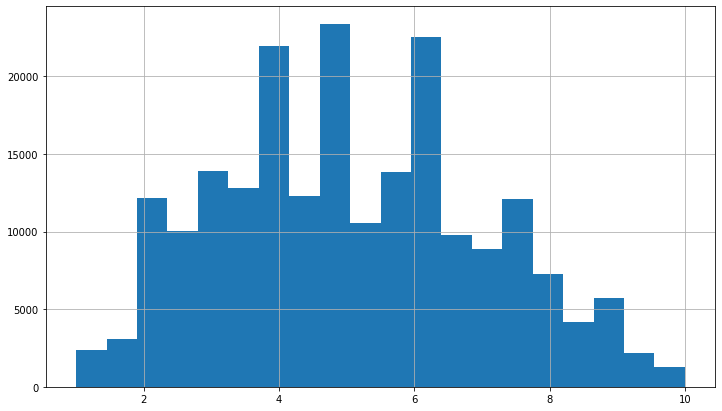

In [169]:
plt.figure(figsize = (12,7))
df['average_school_rating'].hist(bins=20)

In [170]:
num_cols.append('average_school_rating')

2. Количество рядом расположенных школ - 'number_of_schools.

In [171]:
df['number_of_schools'] = df['schools'].apply(lambda x: len(x[0]['rating']))

In [172]:
type(df['number_of_schools'][0])

numpy.int64

In [173]:
df['number_of_schools'].value_counts()

3     129821
2      21355
5      12968
8      12940
4      12443
1       5028
6       4354
7       2091
24      1748
0       1717
22      1368
13       864
12       688
63       532
11       434
15       422
10       377
14       366
65       326
49       152
61       108
9         91
16        20
17        10
26         8
21         4
19         3
Name: number_of_schools, dtype: int64

Нулевое значение мы принимаем за отсутсвие информации о школе, поэтому заменим эти значения на медианное количество школ. Посчитаем медианное количество школ, расположенных около дома.

In [174]:
round(df['number_of_schools'].median())

3

In [175]:
df['number_of_schools'] = df['number_of_schools'].apply(lambda x: 3 if x == 0 else x)
df['number_of_schools'].value_counts()

3     131538
2      21355
5      12968
8      12940
4      12443
1       5028
6       4354
7       2091
24      1748
22      1368
13       864
12       688
63       532
11       434
15       422
10       377
14       366
65       326
49       152
61       108
9         91
16        20
17        10
26         8
21         4
19         3
Name: number_of_schools, dtype: int64

Посмотрим на гистограмму распределения:

<AxesSubplot:>

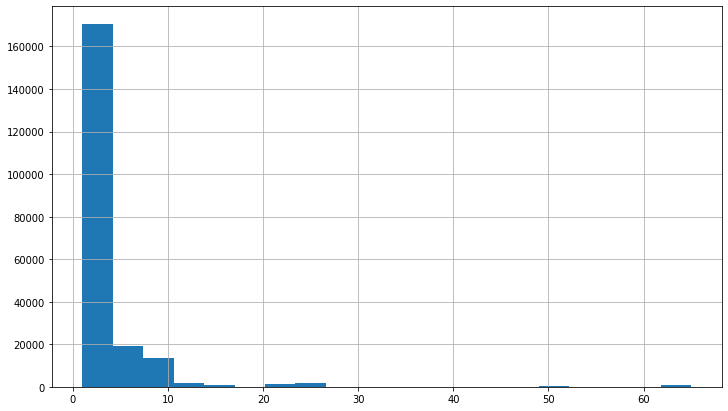

In [176]:
plt.figure(figsize = (12,7))
df['number_of_schools'].hist(bins = 20)

Визуально заметны выбросы - отфильтруем их, воспользовавшись функцией outliers_z_score.

In [177]:
df['number_of_schools'].loc[outliers_z_score(df['number_of_schools'], threshold = 2)].sort_values()

118737    15
190790    15
86667     15
144656    15
86606     15
          ..
165229    65
88187     65
87844     65
98058     65
95309     65
Name: number_of_schools, Length: 4701, dtype: int64

Выявлено 4688 выбросов. Удалим их.

In [178]:
df.drop(outliers_z_score(df['number_of_schools'], threshold = 2), inplace = True)
df.reset_index(inplace = True, drop = True)

<AxesSubplot:>

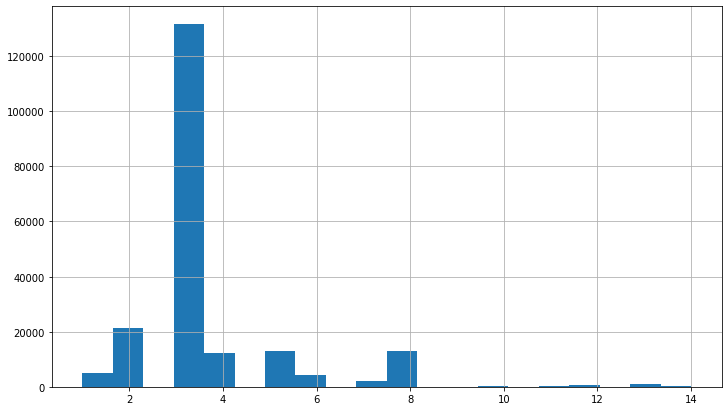

In [179]:
plt.figure(figsize = (12,7))
df['number_of_schools'].hist(bins = 20)

In [180]:
num_cols.append('number_of_schools')

3. Среднее расстояние до школ в милях - 'average_distance_to_school'.

In [181]:
df['average_distance_to_school'] = df['schools'].apply(lambda x: x[0]['data']['Distance'])

In [182]:
df['average_distance_to_school'].isna().sum()

0

Пропуски отсутствуют. Посмотрим на структуру данных.

In [183]:
for i in range(5):
    print(df['average_distance_to_school'].loc[i])

['1.65mi', '1.32mi', '1.01mi']
['1.05mi', '0.1mi', '1.05mi', '0.81mi']
['5.96mi', '3.25mi', '3.03mi']
[]
['0.7 mi', '0.4 mi', '2.2 mi']


Извлечём числовые показатели и посчитаем среднее расстояние до окружающих школ.

In [184]:
pattern = re.compile('\d+[.]\d+')

for i in df.index:
    sum_distances = 0
    count = 0
    for item in df['average_distance_to_school'].loc[i]:
        if len(pattern.findall(item)) != 0:
            sum_distances += float(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        df['average_distance_to_school'].loc[i] = 0
    else:
        df['average_distance_to_school'].loc[i] = round(sum_distances/count, 1)

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\852600469.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['average_distance_to_school'].loc[i] = round(sum_distances/count, 1)
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\852600469.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['average_distance_to_school'].loc[i] = 0


In [185]:
df['average_distance_to_school'].value_counts()

1.1     8879
1.2     8520
0.9     8252
1.0     8147
1.4     7728
        ... 
37.9       1
24.0       1
31.7       1
26.8       1
27.1       1
Name: average_distance_to_school, Length: 312, dtype: int64

Посмотрим сколько в столбце нулевых значений.

In [186]:
len(df[df['average_distance_to_school'] == 0])

1965

Нулевое значение подразумевает отсутствие информации о рейтингах школ. Таких значений 2001. Заменим нули медианным значением, округлённым до целого.

In [187]:
# Отфильтруем нули в столбце и посчитаем среднее
round(df[df['average_distance_to_school'] != 0]['average_distance_to_school'].median())

2

In [188]:
# Заменим средним арифметическим нулевые значения
df['average_distance_to_school'] = df['average_distance_to_school'].apply(lambda x: 2 if x == 0 else x)

Далее для лучшей интерпретации расстояния целесообразно перевести мили в км.

In [189]:
df['average_distance_to_school'] = df['average_distance_to_school'].apply(lambda x: x*1.6)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

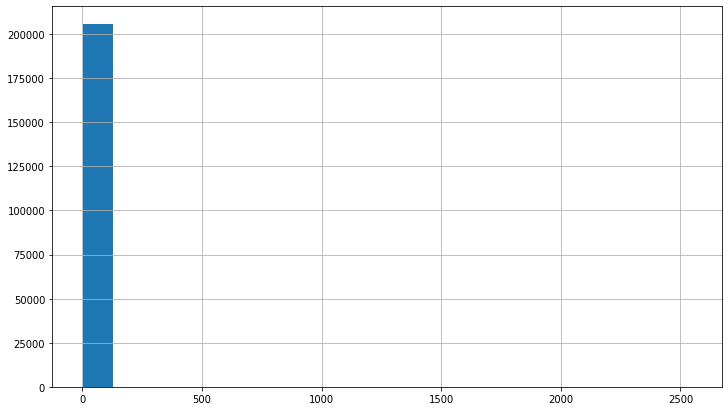

In [190]:
plt.figure(figsize = (12,7))
df['average_distance_to_school'].hist(bins=20)

Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

In [191]:
df['average_distance_to_school'].loc[outliers_iqr(df['average_distance_to_school'])].sort_values()

7930         9.92
65087        9.92
119286       9.92
8263         9.92
107178       9.92
           ...   
125934    1160.80
163871    1160.80
202674    1160.80
59801     2545.28
194439    2545.28
Name: average_distance_to_school, Length: 19531, dtype: float64

Выявлено 20423 выброса. Удалим их.

In [192]:
df = df.drop(outliers_iqr(df['average_distance_to_school']))
df.reset_index(inplace = True, drop = True)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

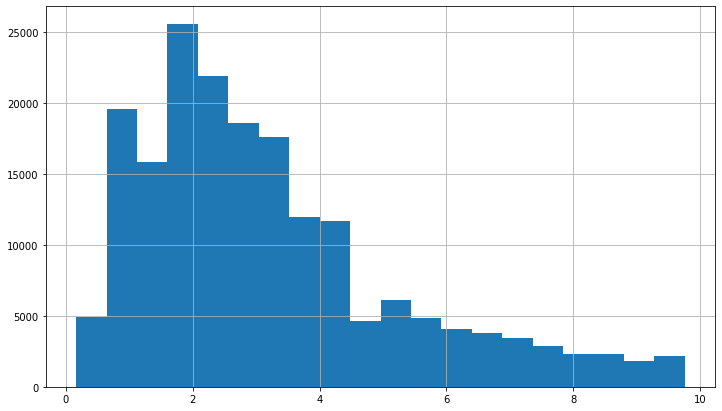

In [193]:
plt.figure(figsize = (12,7))
df['average_distance_to_school'].hist(bins=20)

Распределение имеет правый хвост.

In [194]:
num_cols.append('average_distance_to_school')

In [195]:
df.drop('schools', axis = 1, inplace = True)

## 9. sqft

- жилая площадь в квадратных футах; тип данных - **object**

In [196]:
df.sqft.nunique()

17002

In [197]:
df.sqft.isna().sum()

25218

In [198]:
df.sqft.value_counts()[:50]

0             4529
1,200 sqft     424
1,800 sqft     309
2,000 sqft     295
1,500 sqft     295
1,000 sqft     289
1,400 sqft     284
1,100 sqft     283
1,600 sqft     255
2,400 sqft     222
1,300 sqft     217
2,200 sqft     213
--             206
960 sqft       203
1,440 sqft     203
2,100 sqft     197
3,000 sqft     184
1,120 sqft     176
1,320 sqft     165
2,500 sqft     163
1,900 sqft     162
1,700 sqft     161
1,250 sqft     159
900 sqft       157
1,152 sqft     156
2,300 sqft     150
1,200          149
1,350 sqft     146
800 sqft       146
1,450 sqft     145
1,080 sqft     143
1,056 sqft     143
1,050 sqft     143
1,650 sqft     141
1,260 sqft     141
1,344 sqft     136
-- sqft        133
1,500          128
1,248 sqft     127
1,680 sqft     126
1,008 sqft     125
2,600 sqft     123
1,170 sqft     123
1,296 sqft     120
850 sqft       119
1,560 sqft     119
840 sqft       117
1,100          116
1,750 sqft     115
1,040 sqft     110
Name: sqft, dtype: int64

В столбце 16970 уникальных значений и 27834 пропуска. Преобразуем столбец в числовой тип данных и заполним пропуски и значения, которые будем считать пропусками, средним арифметическим. Пропусками также будем считать значения '0', '--' и '-- sqft'. Сначала отфильтруем пропуски и все значения, которые считаем пропусками, затем преобразуем столбец в числовой формат, переведём все значения в квадратные метры (m^2) и посчитаем медиану.

In [199]:
pattern = re.compile('\d+[,]?\d+')

# Фильтруем все значения, которые считаем пропусками
sub_df = df[(df.sqft != '0') & (df.sqft != '--') & (df.sqft != '-- sqft') & (pd.isna(df.sqft) != True)]

# Выделяем числовые значения
for i in sub_df.index:
    if len(pattern.findall(sub_df.sqft.loc[i])) != 0:
        sub_df['sqft'].loc[i] = pattern.findall(sub_df.sqft.loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

# Убираем запятые
sub_df['sqft'] = sub_df['sqft'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
sub_df['sqft'] = sub_df['sqft'].apply(lambda x: int(x))

# Считаем среднее в столбце
round(sub_df['sqft'].median())

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\1773546297.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['sqft'].loc[i] = pattern.findall(sub_df.sqft.loc[i])[0]
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\1773546297.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop(i, axis = 0, inplace = True)
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\1773546297.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\1773546297.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop(i, axis = 0, inplace = True)
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\1773546297.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['sqft'].loc[i] = pattern.findall(sub_df.sqft.loc[i])[0]
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\1773546297.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

1860

Теперь в исходном датафрейме df заменим пропуски и значения '0', '--' и '-- sqft' на значение '1847'.

In [200]:
df['sqft'] = df['sqft'].apply(lambda x: '1847' if (x == '0') | (x == '--') | (x == '-- sqft') | (pd.isna(x) == True) else x)

Снова проделаем те же операции со столбцом, что и в датафрейме sub_df для того, чтобы получить числовой формат с размерностью m^2.

In [201]:
pattern = re.compile('\d+[,]?\d+')

# Выделяем числовые значения
df['sqft'] = df['sqft'].apply(lambda x: '1847' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

# Убираем запятые
df['sqft'] = df['sqft'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
df['sqft'] = df['sqft'].apply(lambda x: int(x))

# Приводим всё к размерности [кв.м.]
df['sqm'] = df['sqft'].apply(lambda x: round(x/10.764))

Удалим столбец sqft, так как он больше не нужен.

In [202]:
df.drop('sqft', axis = 1, inplace = True)

Посмотрим на гистограмму распределения признака:

<AxesSubplot:>

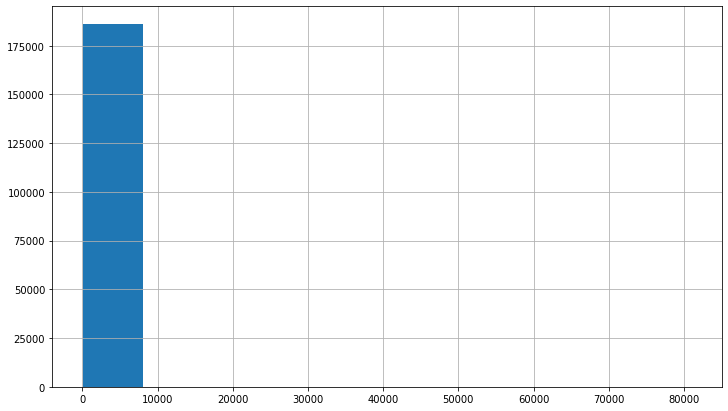

In [203]:
plt.figure(figsize = (12,7))
df.sqm.hist()

Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

In [204]:
df.sqm.loc[outliers_iqr(df.sqm)].sort_values()

131648        5
134617        5
92768       351
153480      351
14464       351
          ...  
12414     54632
152281    62993
22405     72843
60619     73774
99824     80977
Name: sqm, Length: 10284, dtype: int64

Выявлено 11582 выброса. Удалим их.

In [205]:
df.drop(outliers_iqr(df.sqm), inplace = True)
df.reset_index(inplace = True, drop = True)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

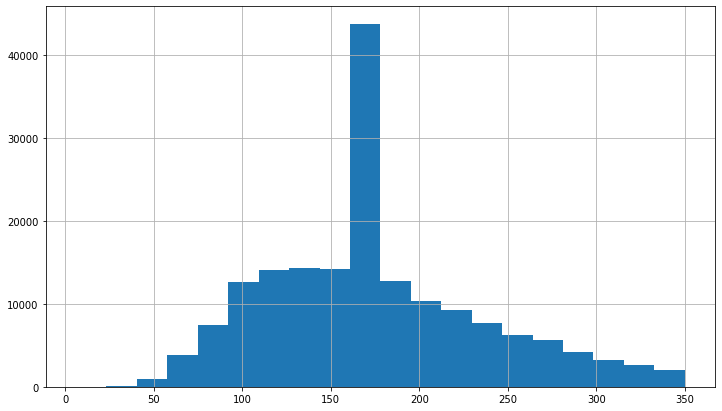

In [206]:
plt.figure(figsize = (12,7))
df.sqm.hist(bins=20)

In [207]:
num_cols.append('sqm')

## 10. zipcode

- почтовый индекс; тип данных - **object**.

In [208]:
df.zipcode.nunique()

3689

In [209]:
df.zipcode.isna().sum()

0

Данный признак не несёт никакой смысловой нагрузки, поэтому удалим его.

In [210]:
df.drop('zipcode', axis = 1, inplace = True)

## 11. beds

- количество спальных комнат; тип данных - **object**.

In [211]:
df.beds.nunique()

85

In [212]:
df.beds.isna().sum()

35238

In [213]:
df.beds.value_counts()[:50]

3 Beds     34438
4 Beds     21390
3          17206
2 Beds     12986
4          10182
3 bd        8538
2           6484
4 bd        5163
5 Beds      4291
2 bd        3120
Baths       3083
3.0         2550
5           1978
4.0         1617
1           1359
5 bd        1078
6 Beds      1014
1 bd         531
-- bd        439
Bath         412
2.0          383
0            364
6            298
             257
7 Beds       244
8 Beds       223
5.0          206
6 bd         159
9 Beds        83
6.0           62
7             49
8             43
10 Beds       32
7 bd          30
64 Beds       24
8 bd          23
0.0           23
12 Beds       17
1.0           15
11 Beds       15
9              7
9 bd           6
8.0            6
7.0            4
12             4
10             3
11             2
18 Beds        2
11 bd          2
16 Beds        2
Name: beds, dtype: int64

Данный признак является слишком грязным, к тому же здесь очень много пропусков. Принимаем решение не использовать его и удалить.

In [214]:
df.drop('beds', axis = 1, inplace = True)

## 12. state

- штат; тип данных - **object**.

In [215]:
df.state.nunique()

36

In [216]:
df.state.isna().sum()

0

В столбце 37 уникальных значений и 0 пропусков.

In [217]:
df.state.value_counts()[:10]

FL    52158
TX    47340
NC     9536
NY     9243
TN     8472
CA     7728
NV     6181
OH     5156
WA     5050
IL     4818
Name: state, dtype: int64

In [218]:
states_with_freqs = list(df.state.value_counts())
top_states_count = int(np.percentile(states_with_freqs, 85))
top_states_count

7341

Выделим 6 самых популярных штатов, которые описывают 85% случаев. Остальные штаты представим значением other.

In [219]:
df.state.value_counts().index[:6]

Index(['FL', 'TX', 'NC', 'NY', 'TN', 'CA'], dtype='object')

In [220]:
all_states = set(df['state'].value_counts().index)
main_states = set(df['state'].value_counts().index[:6])
states_to_drop = list(all_states - main_states)
df.loc[df['state'].isin(states_to_drop), 'state'] = 'other'

In [221]:
cat_cols.append('state')

## 13. stories

- количество этажей; тип данных - **object**.

In [222]:
df.stories.nunique()

142

In [223]:
df.stories.isna().sum()

61999

In [224]:
df.stories.value_counts()[:50]

1.0                      41216
2.0                      34216
1                         9430
2                         6861
3.0                       6455
0.0                       3736
0                         2256
3                         1421
One                       1309
9.0                       1184
4.0                       1145
2.00                       677
Two                        391
1.50                       336
4                          263
9                          244
1.00                       221
5.0                        220
1 Story                    218
One Story                  187
2 Story                    169
8.0                        128
6.0                        123
Ranch/1 Story               96
7.0                         80
1 Level, Site Built         80
Two Story or More           68
6                           57
1 Level                     56
Three Or More               54
Lot                         51
5                           47
2 Level,

Данный признак является слишком грязным, к тому же здесь очень много пропусков. Принимаем решение не использовать его и удалить.

In [225]:
df.drop('stories', axis = 1, inplace = True)

## 14. mls-id

- уникальный идентификатор продажи; тип данных - **object**.

In [226]:
df['mls-id'].nunique()

15282

In [227]:
df['mls-id'].isna().sum()

160424

Большинство значений данного столбца пропущены, поэтому удалим его.

In [228]:
df.drop('mls-id', axis = 1, inplace = True)

## 15. PrivatePool

- наличие бассейна; тип данных - **object**.

In [229]:
df.PrivatePool.nunique()

2

In [230]:
df.PrivatePool.isna().sum()

158272

In [231]:
df.PrivatePool.value_counts()

yes    12673
Yes     4777
Name: PrivatePool, dtype: int64

Данный столбец дублирует столбец private pool. Удалим его.

In [232]:
df.drop('PrivatePool', axis = 1, inplace = True)

## 16. MlsId

- уникальный идентификатор продажи; тип данных - **object**.

In [233]:
df.MlsId.nunique()

115668

In [234]:
df.MlsId.isna().sum()

40625

In [235]:
df.MlsId.value_counts()[:50]

NO MLS                      19
 A, Houston, TX 77008       13
No MLS #                    12
 B, Houston, TX 77008        9
 B, Houston, TX 77007        8
No                           7
 A, Austin, TX 78721         6
 A, Houston, TX 77018        5
1412350                      5
1520876                      4
 B, Austin, TX 78751         4
U8054073                     4
3555874                      4
 B, Austin, TX 78721         4
DCDC437828                   4
30656755                     4
 A, Austin, TX 78704         4
3565174                      4
3571699                      4
 B, Houston, TX 77054        4
3535121                      4
DCDC435032                   4
 A, Austin, TX 78745         4
 C, Houston, TX 77007        4
DCDC447282                   4
 101, Dallas, TX 75204       4
10061790                     4
1027692                      4
682831                       4
 1, Washington, DC 20010     4
 A, Austin, TX 78723         4
 B, Houston, TX 77057        4
F1017878

В датасете необходимо удалить дубликаты. Это удобно сделать по столбцу MlsId. В данном столбце 122638 уникальных значений и 42046 пропусков. Отфильтруем их, а потом удалим дубликаты.

In [236]:
df1 = df[df.MlsId.isnull() == False]
df2 = df[df.MlsId.isnull() == True]

In [237]:
df1.drop_duplicates(subset = 'MlsId', inplace = True)

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\4035173818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop_duplicates(subset = 'MlsId', inplace = True)


In [238]:
df = pd.concat([df1, df2], axis = 0)
df.reset_index(inplace = True, drop = True)

In [239]:
df.shape

(156293, 18)

В результате очистки датасета от дубликатов осталось 164684 строки. Удалим столбец MlsId, так как он больше не нужен.

In [240]:
df.drop('MlsId', axis = 1, inplace = True)

## 17. target

In [241]:
df.target.nunique()

25536

In [242]:
df.target.isna().sum()

1102

In [243]:
df.target.value_counts()[:50]

$225,000    752
$275,000    693
$250,000    689
$249,900    665
$299,900    662
$199,900    642
$350,000    613
$325,000    612
$175,000    573
$375,000    544
$235,000    541
$399,000    533
$215,000    528
$299,000    525
$265,000    517
$185,000    512
$239,900    511
$165,000    510
$150,000    504
$425,000    499
$285,000    497
$179,900    487
$450,000    486
$149,900    484
$189,900    484
$399,900    480
$349,900    473
$169,900    463
$269,900    453
$315,000    452
$220,000    444
$159,900    440
$499,000    439
$125,000    437
$295,000    435
$259,900    434
$210,000    428
$245,000    424
$195,000    404
$229,900    404
$300,000    403
$200,000    401
$279,900    401
$289,900    399
$199,000    399
$139,900    398
$219,900    395
$145,000    391
$135,000    377
$230,000    365
Name: target, dtype: int64

Столбец имеет 25612 уникальных значений и 1138 пропусков. Преобразуем столбец в числовой тип данных и заполним пропуски медианой. Сначала отфильтруем пропуски, затем преобразуем столбец в числовой формат и посчитаем среднее арифметическое.

In [244]:
pattern = re.compile('\d+[,]?\d+')

# Фильтруем пропуски
sub_df = df[pd.isna(df.target) != True]

# Выделяем числовые значения
for i in sub_df.index:
    if len(pattern.findall(sub_df.target.loc[i])) != 0:
        sub_df['target'].loc[i] = pattern.findall(sub_df.target.loc[i])[0]
    else:
        sub_df.drop(i, axis = 0, inplace = True)

# Убираем запятые
sub_df['target'] = sub_df['target'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
sub_df['target'] = sub_df['target'].apply(lambda x: int(x))

# Считаем среднее в столбце
round(sub_df['target'].median())

C:\Users\anton\AppData\Local\Temp\ipykernel_13064\565808498.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['target'].loc[i] = pattern.findall(sub_df.target.loc[i])[0]


C:\Users\anton\AppData\Local\Temp\ipykernel_13064\565808498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop(i, axis = 0, inplace = True)
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\565808498.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['target'].loc[i] = pattern.findall(sub_df.target.loc[i])[0]
C:\Users\anton\AppData\Local\Temp\ipykernel_13064\565808498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

255600

Теперь в исходном датафрейме df заполним пропуски значением '255000'.

In [245]:
df['target'] = df['target'].fillna('255000')

Снова проделаем те же операции со столбцом, что и в датафрейме sub_df для того, чтобы получить числовой формат.

In [246]:
pattern = re.compile('\d+[,]?\d+')

# Выделяем цифровые показатели
df['target'] = df['target'].apply(lambda x: '255000' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

# Убираем запятые
df['target'] = df['target'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
df['target'] = df['target'].apply(lambda x: int(x))

Посмотрим на гистограмму распределения признака:

<AxesSubplot:>

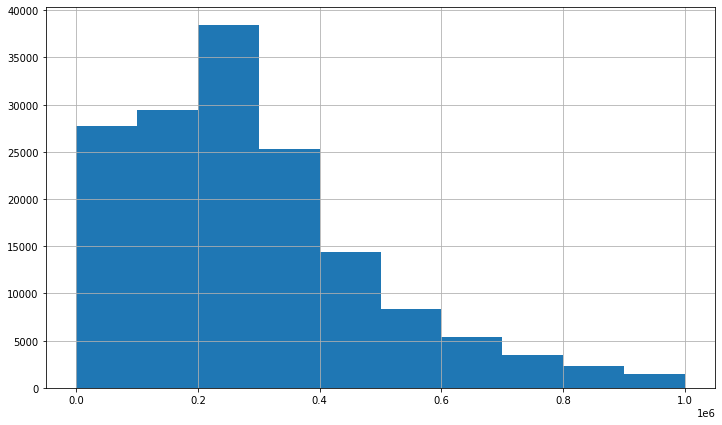

In [247]:
plt.figure(figsize = (12,7))
df.target.hist()

Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

In [248]:
df.target.loc[outliers_iqr(df.target)].sort_values()

110317    747831
151093    747990
118361    748000
34116     748000
52606     748000
           ...  
81472     999999
75085     999999
13452     999999
52719     999999
53239     999999
Name: target, Length: 6079, dtype: int64

Выявлено 6183 выброса. Удалим их.

In [249]:
df = df.drop(outliers_iqr(df.target))
df.reset_index(inplace = True, drop = True)

Посмотрим на гистограмму распределения:

<AxesSubplot:>

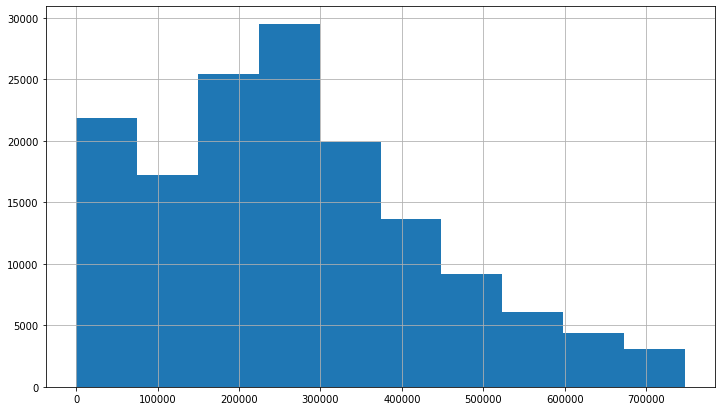

In [250]:
plt.figure(figsize = (12,7))
df.target.hist()

In [251]:
num_cols.append('target')

In [252]:
df.shape

(150214, 17)

## Feature engineering

Создадим полиномиальные признаки на основе столбцов sqm и price/sqm.

In [253]:
pf = PolynomialFeatures(2)

poly_features = pf.fit_transform(df[['sqm', 'price/sqm']])
new_df = pd.DataFrame(poly_features, columns = ['1', 'sqm', 'price/sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2'])
new_df.drop(['1', 'sqm', 'price/sqm'], axis = 1, inplace = True)
df = pd.concat([df, new_df], axis = 1)

Таким образом мы получили ещё три числовых признака sqm^2, sqm_price/sqm и price/sqm^2.

In [254]:
df.shape

(150214, 20)

Выгрузим данные в csv для дальнейшего обучения.

In [255]:
# df.to_csv('data_preproc.csv', index = False)

В результате EDA получен датасет с размерностью (152897, 20). При этом размерность исходного датасета (377185, 18). Получено 8 числовых признаков (пропуски в них заменены на медиану, выбросы найдены методом IQR и удалены), 7 категориальных признаков (в них сокращено количество уникальных значений) и 2 бинарных признака. В результате feature engineering было получено ещё 3 числовых признака.

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150214 entries, 0 to 150213
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   propertyType                150214 non-null  object 
 1   fireplace                   150214 non-null  object 
 2   city                        150214 non-null  object 
 3   state                       150214 non-null  object 
 4   target                      150214 non-null  int64  
 5   sale_status                 150214 non-null  object 
 6   full_baths                  150214 non-null  object 
 7   year_built                  150214 non-null  float64
 8   remodeling                  150214 non-null  object 
 9   heating                     150214 non-null  object 
 10  parking                     150214 non-null  object 
 11  lotsize                     150214 non-null  int64  
 12  price/sqm                   150214 non-null  int64  
 13  average_school

In [257]:
import collections
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler

In [258]:
mylist = list(df.columns)
mylist

['propertyType',
 'fireplace',
 'city',
 'state',
 'target',
 'sale_status',
 'full_baths',
 'year_built',
 'remodeling',
 'heating',
 'parking',
 'lotsize',
 'price/sqm',
 'average_school_rating',
 'number_of_schools',
 'average_distance_to_school',
 'sqm',
 'sqm^2',
 'sqm_price/sqm',
 'price/sqm^2']

In [259]:
# Категориальные признаки:
cat_cols = [
'propertyType',
 'fireplace',
 'city',
 'state',
 'sale_status',
 'full_baths',
 'heating',
 'remodeling',
#  'zipcode',
 'parking'
]

# непрерывные признаки:
num_cols = [
 'price/sqm',
 'average_school_rating',
 'average_distance_to_school',
 'number_of_schools',
 'sqm',
 'sqm_price/sqm',
 'price/sqm^2',
 'year_built',
 'lotsize'
]

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

In [261]:
# определим функцию построения корреляционной диаграммы признаков:
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = df[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

In [262]:
# кодируем информацию категориальных признаков:
for col in cat_cols:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes


In [263]:
df.head(10)

,propertyType,fireplace,city,state,target,sale_status,full_baths,year_built,remodeling,heating,parking,lotsize,price/sqm,average_school_rating,number_of_schools,average_distance_to_school,sqm,sqm^2,sqm_price/sqm,price/sqm^2
0,4,0,9,6,310000,1,2,2019.0,0,4,5,541,1711,4.0,3,2.08,181,32761.0,309691.0,2927521.0
1,1,0,9,1,5000,1,4,1985.0,0,4,5,931,1905,4.7,3,6.56,172,29584.0,327660.0,3629025.0
2,5,0,9,6,209000,1,4,1920.0,0,1,5,63,2508,5.0,3,3.20,83,6889.0,208164.0,6290064.0
3,3,0,9,4,68000,0,4,1976.0,0,4,5,813,614,2.7,3,1.76,172,29584.0,105608.0,376996.0
4,4,0,2,5,311995,4,2,2019.0,0,2,2,191,1744,3.0,3,1.76,179,32041.0,312176.0,3041536.0
5,4,0,2,5,168800,4,2,1982.0,1,5,1,198,743,5.3,3,2.24,228,51984.0,169404.0,552049.0
6,3,0,9,1,335000,0,0,2008.0,1,4,5,493,1636,3.5,4,1.12,205,42025.0,335380.0,2676496.0
7,4,1,9,5,365000,1,2,2016.0,0,5,2,968,1281,7.0,2,3.04,286,81796.0,366366.0,1640961.0
8,2,0,9,1,626000,1,2,1954.0,0,1,5,753,4176,5.0,3,0.64,150,22500.0,626400.0,17438976.0
9,4,1,9,5,499007,1,2,2019.0,0,0,2,740,1475,8.3,3,5.12,339,114921.0,500025.0,2175625.0


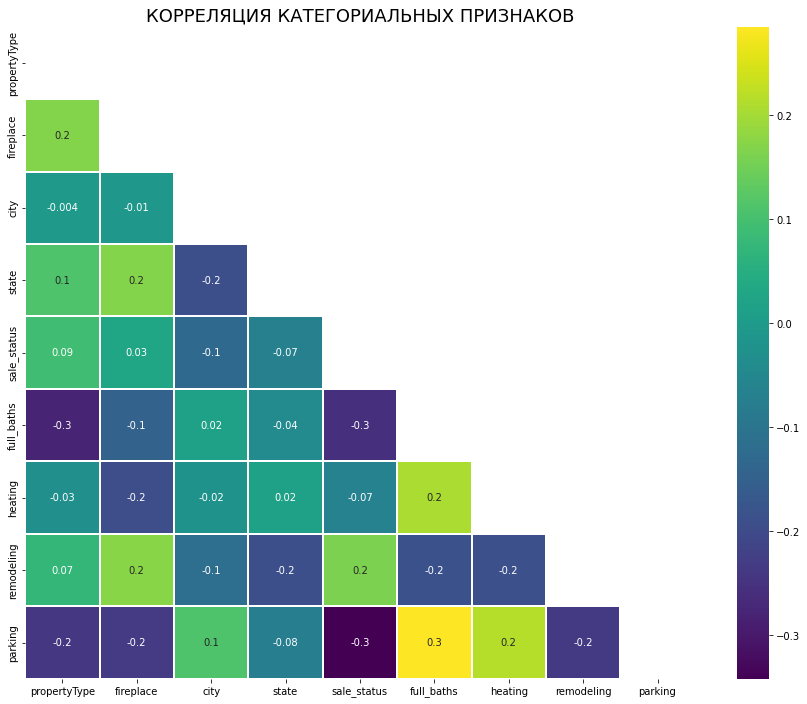

In [264]:
#строим диаграмму для категориальных признаков:
show_corr_heatmap(cat_cols, 'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ', method='pearson');

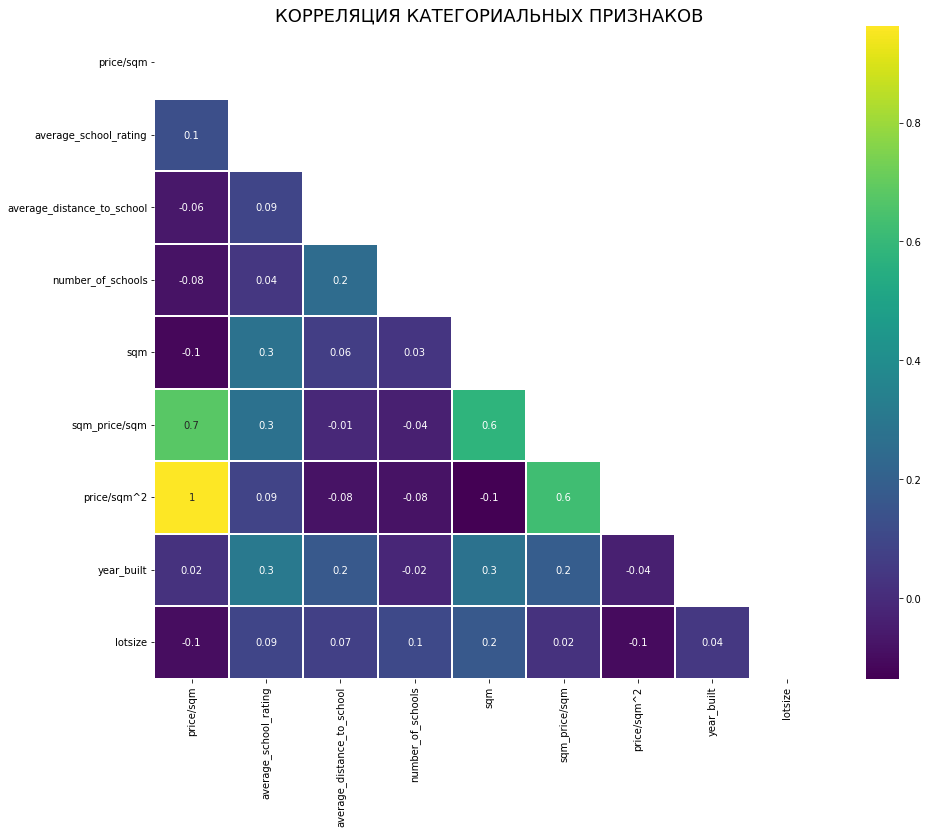

In [265]:
#строим диаграмму для непрерывных признаков:
show_corr_heatmap(num_cols, 'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ', method='pearson');

In [266]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
data_mm = mm_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
col_names = list(df.columns)
data_mm = pd.DataFrame(data_mm, columns=col_names)

In [267]:
# 
X = data_mm.drop(['target'], axis = 1)  
y = data_mm['target'] 

In [268]:
# # 
# from sklearn.feature_selection import chi2 # хи-квадрат

# imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh', figsize=(10, 4), color='green') 

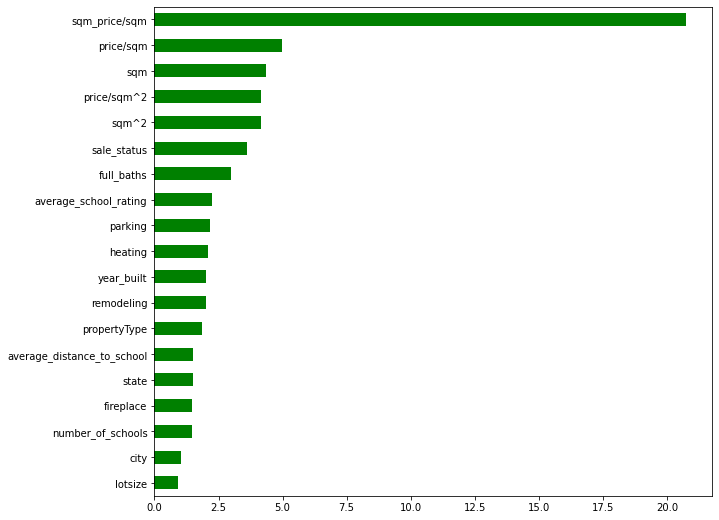

In [269]:
# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X, y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(10, 9))
imp_num.plot(kind = 'barh', color='green');

In [270]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [271]:
y = df['target']
X = df.drop(columns='target')

In [272]:
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (105149, 19) (105149,)
Test: (45065, 19) (45065,)


In [273]:
from sklearn import metrics # инструменты для оценки точности модели

In [274]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

In [275]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [276]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train) 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))
print('MAPE:', round(mean_absolute_percentage_error(y_test, y_test_predict), 2))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_test_predict))

Train R^2: 0.528
Test R^2: 0.534
MAPE: 855.49
MAPE: 8.554902339037286


In [277]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))


Train shape: (105149, 209)
Test shape: (45065, 209)


In [278]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly))) 
print('MAPE:', round(mean_absolute_percentage_error(y_test, y_test_predict_poly), 2))

Train R^2: 0.723
Test R^2: 0.726
MAPE: 575.2


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.185e+14, tolerance: 3.042e+11
  model = cd_fast.enet_coordinate_descent(


In [279]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
print('MAPE:', round(mean_absolute_percentage_error(y_test, y_test_predict_poly), 2))

Train R^2: 0.707
Test R^2: 0.710
MAPE: 600.23
